Univariate on close price series. Single GPU cuz multi is FKD UP, 

In [1]:
EXP_NAME = "DARTS_NBEATS_univar_v5"
EPOCHS = 10000 #nb
LOOKBACK = 3600 # 1hr
FORWARD = 600 # 10 mins

In [2]:
#======Core============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#======PytorchLightning===========
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
#======Darts===========
from darts.models import NBEATSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#from ue.uexp.dataprocessing.ta import *
#from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta

import warnings
warnings.filterwarnings('ignore')

import time
from datetime import timedelta
startTime = time.time()

Importing plotly failed. Interactive plots will not work.


# Data Processing

In [18]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-20"
end_date = "2022-02-21"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-19.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-20.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-21.csv


In [19]:
df.head()

,open,high,low,close,volume,tic
2022-02-20 00:00:00,40079.17,40082.62,40077.30,40082.62,0.13628,BTCUSDT
2022-02-20 00:00:01,40082.62,40087.28,40082.62,40087.28,0.10610,BTCUSDT
2022-02-20 00:00:02,40087.27,40087.28,40087.27,40087.27,0.01677,BTCUSDT
2022-02-20 00:00:03,40087.28,40087.28,40087.27,40087.28,0.00348,BTCUSDT
2022-02-20 00:00:04,40087.28,40087.28,40087.27,40087.28,0.01393,BTCUSDT


In [20]:
df = df[['close']]

In [21]:
# # for > 1s data
# df = df[['time', 'close']]
# df['time'] = pd.to_datetime(df['time'])
# df.set_index('time', inplace=True)

In [22]:
# use 4*1024*10 / 0.8 (we need 40960 for the 80% train, + 20% val) = 51200
# 102400 --> 81920 -> 4*1024*[20], 20480 -> 4*1024*[5]
# IGNORE ^
df = df[:50000]

In [23]:
dfts = TimeSeries.from_dataframe(df)

In [24]:
# optimize
dfts = dfts.astype(np.float32)
assert dfts.dtype == np.float32

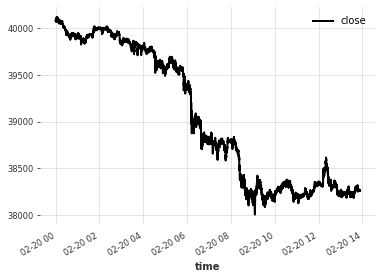

In [25]:
dfts.plot()

In [26]:
scaler = Scaler()
# [0] because singular
train_og, val_og = dfts.split_after(0.8)
scaled_series = scaler.fit_transform(dfts)
# optimize
scaled_series = scaled_series.astype(np.float32)
train, val = scaled_series.split_after(0.8)

In [27]:
len(train_og), len(val_og)

(40000, 10000)

## Model

In [28]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

In [29]:
# # from example.ipynb
# model = NBEATSModel(
#     input_chunk_length=30,
#     output_chunk_length=7,
#     generic_architecture=True,
#     num_stacks=10,
#     num_blocks=1,
#     num_layers=4,
#     layer_widths=512,
#     n_epochs=100,
#     nr_epochs_val_period=1,
#     batch_size=1024,
#     model_name="nbeats_run",
#     pl_trainer_kwargs={
#         "accelerator": "gpu",
#         "gpus": [0],
#         "enable_progress_bar": False,
#         # "callbacks": [my_stopper],
#     }
# )

In [30]:
# for reference: https://github.com/unit8co/darts/issues/802
model = NBEATSModel(
    model_name=EXP_NAME,
    work_dir="model_data",
    input_chunk_length=LOOKBACK,
    output_chunk_length=FORWARD,
    generic_architecture=True,
    batch_size=1024,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "gpus": [2],
        "enable_progress_bar": False,
        #"callbacks": [my_stopper],
    }
)

# Dead Notes:
# Strategies for interactive: dp, ddp_spawn
# Recommended: ddp (but not for interactive)
# source: https://pytorch-lightning.readthedocs.io/en/stable/advanced/multi_gpu.html#select-gpu-devices
# "num_nodes": 4,
#"precision":16, # need to .astype(np.float16 in our dataset to use precision16)
#"plugins": DDPPlugin(find_unused_parameters=False), # get rid of warnings: https://github.com/PyTorchLightning/pytorch-lightning/discussions/6761


In [31]:
model.fit(
    series=train,
    val_series=val,
    epochs=EPOCHS,
)
#trainer=trainer) #lol their default trainer looks pretty good
# NOTE: known bug of  module 'distutils' has no attribute 'version' as per https://stackoverflow.com/questions/70520120/attributeerror-module-setuptools-distutils-has-no-attribute-version

[2022-03-03 15:34:35,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 35801 samples.
[2022-03-03 15:34:35,936] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 35801 samples.
[2022-03-03 15:34:36,144] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-03-03 15:34:36,144] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 34.4 M
-----------------------------------------
34.4 M    Trainable params
22.9 K    Non-trainable params
34.4 M    Total params
137.640   Total estimated model params si

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# training was for horizon=30, if predict here horizon>15 then need historic_future_covs but nbeats doesnt support future Covs atm
pred_train = model.predict(series=train, n=30)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 16it [00:00, ?it/s]

In [17]:
# scale back:
pred_train_scaled = scaler.inverse_transform(pred_train)

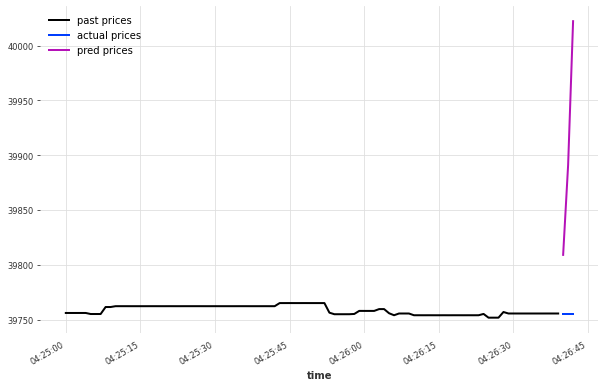

In [18]:
plt.figure(figsize=(10, 6))
# prev train
train_og[-100:].plot(label="past prices")
#actual
val_og[:3].plot(label="actual prices")
# pred
pred_train_scaled[:3].plot(label="pred prices")

In [20]:
# model.save_model(EXP_NAME+".pth.tar")

## Historical Forecast

In [ ]:
hist_for = model.historical_forecasts(
    series=train,
    start=0.95, #just the last 5 percent
    forecast_horizon=30,
    #stride=5,
    retrain=False,
    verbose=False, #too many bars...doesnt stop it
)

In [22]:
# rescale
# scale back:
hist_for = scaler.inverse_transform(hist_for)

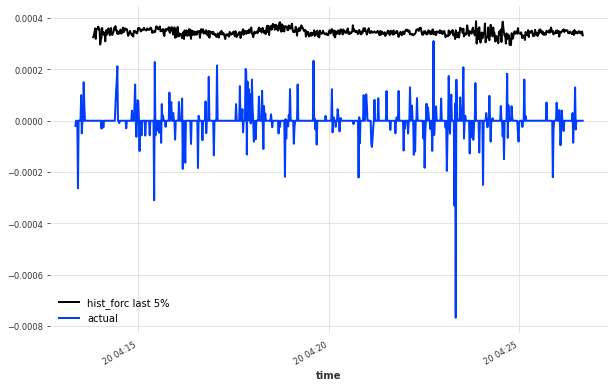

In [23]:
plt.figure(figsize=(10, 6))
hist_for.plot(label="hist_forc last 5%")
last5pct = int(len(train)*0.05)
train_og[-last5pct:].plot(label="actual")

In [ ]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time:', str(timedelta(seconds=executionTime)))